In [1]:
import numpy as np

from Analysis_utils import *
from Plots import *
from scipy.interpolate import CubicSpline

# 3D Embedding

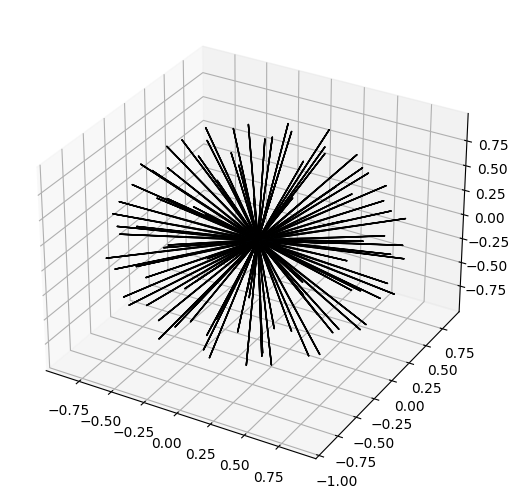

In [2]:
m = Manifold(200)
plot_triangulation_3d(m.adj)

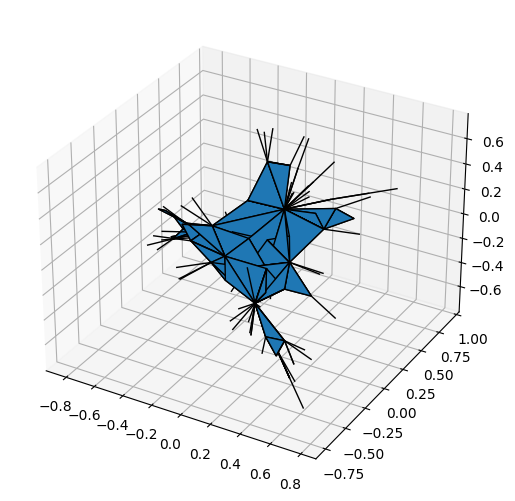

In [3]:
n_sweeps = 200
m.sweep(n_sweeps, 0.1, strategy=['scalar', 'gravity'])
plot_triangulation_3d(m.adj)

In [4]:
is_sphere_triangulation(m.adj)

True

# Graph Representation

In [5]:
l2 = Manifold(4)
l2.sweep(1000)
adj = l2.adj
num_vert, vertex = vertex_list(adj)
edges = triangulation_edges(adj, vertex)
triangles = triangulation_triangles(adj, vertex)
G = nx.Graph(edges)

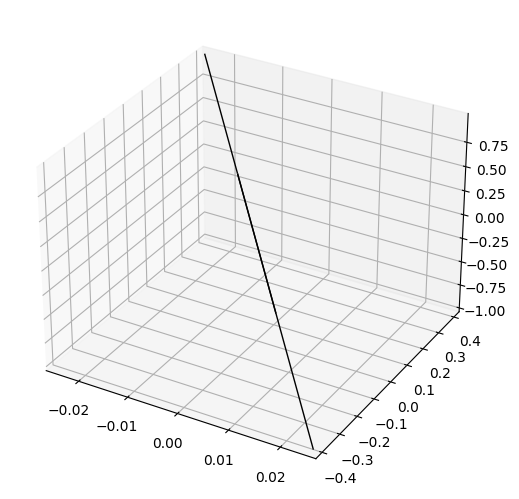

In [6]:
plot_triangulation_3d(l2.adj)

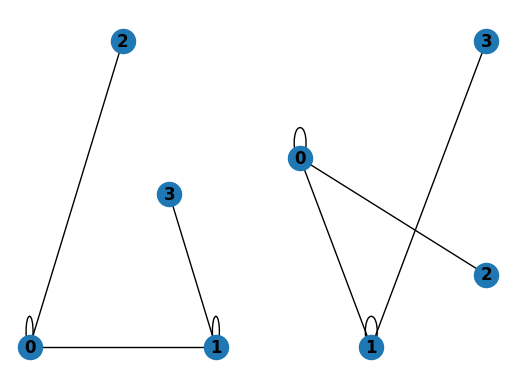

In [7]:
subax1 = plt.subplot(121)
nx.draw_planar(G, with_labels=True, font_weight='bold')
subax2 = plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

# Distance Profile and Haussdorff Dimension

In [8]:
beta=0
sizes = np.array([2*int(i) for i in np.geomspace(10, 20, 3)])
profiles = make_profiles(0, sizes)

20
28
40


[[0.         0.4728708  0.94574161 1.41861241 1.89148322 2.36435402
  2.83722483 3.31009563 3.78296644 4.25583724 4.72870805 5.20157885
  5.67444965 6.14732046 6.62019126]
 [0.         0.43472087 0.86944174 1.30416262 1.73888349 2.17360436
  2.60832523 3.0430461  3.47776698 3.91248785 4.34720872 4.78192959
  5.21665046 5.65137134 6.08609221]
 [0.         0.39763536 0.79527073 1.19290609 1.59054146 1.98817682
  2.38581219 2.78344755 3.18108292 3.57871828 3.97635364 4.37398901
  4.77162437 5.16925974 5.5668951 ]]


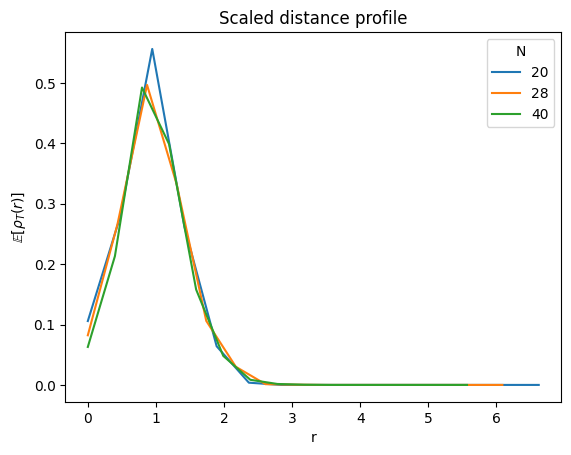

In [9]:
xs, ys = scale_profile(profiles, sizes, 0.25)
print(xs)
overlay_profiles(ys, xs, sizes)

# Finite size scaling

In [10]:
def scale_profile(profiles, sizes, d):
    xs, ys = [], []
    for i, profile in enumerate(profiles):
        rvals = np.arange(len(profile))
        x = rvals / sizes[i] ** d
        y = profile / sizes[i] ** (1 - d)
        xs.append(x), ys.append(y)
        # plt.plot(x, y)
    return np.array(xs), np.array(ys)

def profiles_max(profiles):
    profiles_max = np.max(profiles, axis=1)
    return profiles_max[:,0], profiles_max[:,1]

def power_fit(N, d, a):
    return a*N**d

def lin_fit(x, d, b):
    return b + d*x

def finite_size_scaling(profile, sizes):
    prof_max, sigma_max = profiles_max(profile)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

def finite_size_scaling_fit(profile, sizes):
    prof_max = np.max(profile, axis=1)
    fit = curve_fit(power_fit, sizes, prof_max, p0=[0.75, 1])
    (d, a), err = fit
    d_H = 1/(1-d)
    d_err = np.sqrt(err[0,0])
    d_H_err = d_H**2*d_err
    a_err = np.sqrt(err[1,1])
    return d_H, d_H_err, a, a_err

100
128
166
214
278
358
464
598
774
1000


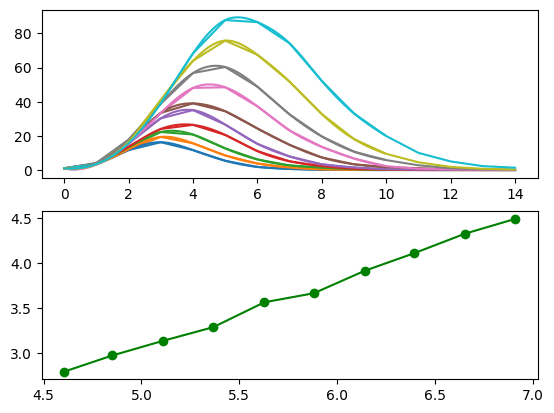

In [13]:
beta=0.3
sizes = [(int(i)//2)*2 for i in np.geomspace(100, 1000, 10)]

prof = make_profiles(beta, sizes, meas_sweeps=10, strategy=['gravity', 'ising'])


prof_0 = prof[..., 0]
rs0 = np.arange
rs = np.arange(0.1, 10, 0.05)
fit_prof = []


fig, ax = plt.subplots(2)
for profile in prof_0:
    dist_range = range(len(profile))
    cs = CubicSpline(dist_range, profile)
    fit_prof.append(cs(rs))
    ax[0].plot(dist_range, profile)

for p in fit_prof:
    ax[0].plot(rs, p)

y = np.log(np.max(fit_prof, axis=1))
x = np.log(sizes)
ax[1].plot(x, y, 'go-')

np.savez('profiles_beta_1', full_prof=prof, fit_prof=np.array(fit_prof), beta=beta)

In [14]:
fit = curve_fit(lin_fit, x, y, p0=[0.75, 0])
(d, a), err = fit
d_H = 1/(1-d)
d_err = np.sqrt(err[0,0])
d_H_err = d_H**2*d_err
a_err = np.sqrt(err[1,1])

print("\nwith spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

d_H, d_H_err, a, a_err = finite_size_scaling(prof, sizes)
print("\nwithout spline fit:")
print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')


with spline fit:
d_H = 3.9903013805572334+/-d_H_err = 0.22617272922610135
a = -0.6855488959580641+/-a_err = 0.08239440691764913

without spline fit:
d_H = 4.189584504047388+/-d_H_err = 0.30752264299644433
a = 0.46305027679565564+/-a_err = 0.05229401807705351


min_d = 3.816326530612245
min_err = 0.0038060916310033487


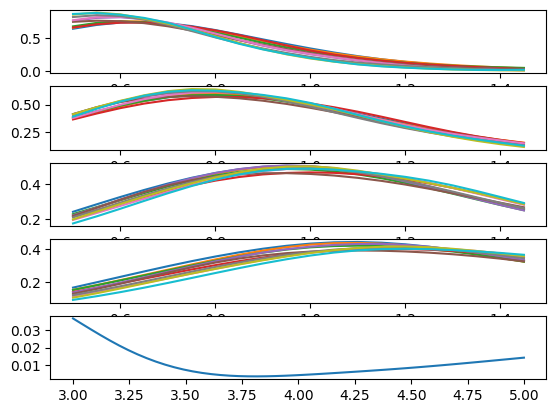

In [15]:
# CHECK ACCEPTANCE RATE OF ISING MOVES.
# RESCALE SPLINES SO THAT THEY HAVE SAME SIZE


steps = 50
n_plots = 4
fig, ax = plt.subplots(n_plots+1)

s = slice(0, None)
prof = np.load('profiles_beta_1.npz')['full_prof'][s]

ds = np.linspace(3, 5, steps)
x_range = np.arange(0.5, 1.5, 0.05)
errors = []
min_err = np.inf
min_d = 0
for i, d in enumerate(ds):
    splines = []
    xs, ys = scale_profile(prof, sizes, 1/d)
    ys = ys[..., 0]
    for x, y in zip(xs, ys):
        cs = CubicSpline(x, y)
        splines.append(cs(x_range))

        interval = int(np.ceil(steps/n_plots))
        if i%interval==0:
            ax[i//interval].plot(x_range, cs(x_range))

    splines = np.array(splines)
    err_spline = np.sum(np.var(splines, axis=0))
    if err_spline < min_err:
        min_err = err_spline
        min_d = d
    errors.append(err_spline)


print(f'{min_d = }')
print(f'{min_err = }')
ax[-1].plot(ds, errors)

In [ ]:
xs, ys = scale_profile(prof, sizes, 1/4)
print(xs)
print(ys[..., 0])
for x, y in zip(xs, ys[..., 0]):
    print(x)
    print(y)

In [ ]:
from scipy.interpolate import CubicSpline
x, y = xss[1], ys[1,:,0]
cs = CubicSpline(x, y)

xs = np.arange(0.1, 5, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, cs(xs), label="S")

print(cs(xs))
ax.legend(loc='lower left', ncol=2)

In [ ]:
beta=0.2
sizes = [(int(i)//2)*2 for i in np.geomspace(80, 200, 5)]

prof = make_profiles(beta, sizes, strategy=['gravity', 'ising'])
d_H, d_H_err, a, a_err = finite_size_scaling(prof)

print(f'{d_H = }' +'+/-'+ f'{d_H_err = }')
print(f'{a = }'+'+/-'+ f'{a_err = }')

plot_profiles(prof, sizes)

In [ ]:
d = 4.2
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)

In [ ]:
d = 4
xs, ys = scale_profile(prof, sizes, 1/d)
overlay_profiles(ys, xs, sizes)